In [1]:
# import necessary linraries
! pip install tensorflow pyarrow
! pip install pandas
! pip install scikit_learn
! pip install matplotlib
! pip install requests

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Layer, LayerNormalization, Dropout


In [7]:
# setup the enviornment to generate syntheic stock price data
# create a data named 'synthetic stock price data' , number = 2000

np.random.seed(42)
data_len = 2000
trend = np.linspace(100,100,data_len)
# divided values between start's value (100) and final's value with 2000's equal value
# trend has always 100 array.
noise =np.random.normal(0,2,data_len)
# avg = , std = 2 의 분포에서 2000개의 난수 생성
synthetic_data = trend + noise

# cteate  daraframe and save with csv
data = pd.DataFrame(synthetic_data, columns=['close'])
data.to_csv('stock_prices.csv',index = False)
print('synthetic stock_prices.csv created and loaded.')

synthetic stock_prices.csv created and loaded.


In [10]:
# load dataset
data = pd.read_csv('stock_prices.csv')
data = data[['close']].values

# normalize data
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

# preparing the data for training
def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step),0]
        X.append(a)
        Y.append(data[i+time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X=X.reshape(X.shape[0],X.shape[1],1)

print("shape of x:",X.shape)
print("shape of y:",Y.shape)

shape of x: (1899, 100, 1)
shape of y: (1899,)


In [11]:
# define the multi-head self - attention mechanism

class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_dim,num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim//num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output= tf.matmul(weights, value)
        return output, weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0,2,1,3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        attention,_ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0,2,1,3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

In [16]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()

        # Multi-Head Self Attention
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # Feed-forward network (FFN)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])

        # Layer Normalization
        self.layernor1 = LayerNormalization(epsilon=1e-6)
        self.layernor2 = LayerNormalization(epsilon=1e-6)

        # Dropout layers
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # Apply multi-head self attention
        attn_output = self.att(inputs, inputs, inputs)  # Query, Key, Value all come from inputs
        attn_output = self.dropout1(attn_output, training=training)

        # Add & normalize (residual connection)
        out1 = self.layernor1(inputs + attn_output)

        # Apply feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        # Add & normalize (residual connection)
        return self.layernor2(out1 + ffn_output)

In [17]:
class EncoderLayer(Layer):

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(EncoderLayer,self).__init__()
        self.att=MultiHeadSelfAttention(embed_dim , num_heads)
        self.ffn=tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernor1=LayerNormalization(epsilon=1e-6)
        self.layernor2=LayerNormalization(epsilon=1e-6)
        self.dropout1=Dropout(rate)
        self.dropout2=Dropout(rate)

    def call(self,inputs,training):
      attn_output = self.att(inputs)
      attn_output = self.dropout1(attn_output,training=training)
      our1 = self.layernor1(inputs + attn_output)
      ffn_output = self.ffn(out1)
      ffn_output = self.dropout2(ffn_output, training= training)
      return self.layernor2(out1 + ffn_output)

In [23]:
class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

# TransformerBlock class
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernor1 = LayerNormalization(epsilon=1e-6)
        self.layernor2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernor1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernor2(out1 + ffn_output)

# TransformerEncoder class
class TransformerEncoder(Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training)
        return x

# Example usage
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

# Instantiate the Transformer encoder
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)

# Correct input shape: (batch_size, seq_length, embed_dim)
inputs = tf.random.uniform((32, 100, embed_dim))  # batch_size=32, seq_len=100, embed_dim=128
outputs = transformer_encoder(inputs, training=False)

print(outputs.shape)

(32, 100, 128)


In [24]:
# build and compile the transformer model
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4
# define the transformer encoder
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)

# build the model
input_shape = (X.shape[1], X.shape[2])
inputs = tf.keras.layers.Input(shape=input_shape)

#project the inputs to the embed_dim
x = tf.keras.layers.Dense(embed_dim)(inputs)
encoder_outputs = transformer_encoder(x)
flatten = tf.keras.layers.Flatten()(encoder_outputs)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# compile model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 100, 128)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_2                │ (None, 100, 128)            │         793,088 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 1)                   │          12,801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# train model
model.fit(X,Y, epochs=20, batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 254ms/step - loss: 12.0460
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1915
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1772
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1665
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1903
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1962
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1343
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1509
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1308
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1467
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0992
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1136
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1060
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0865
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0901
E

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


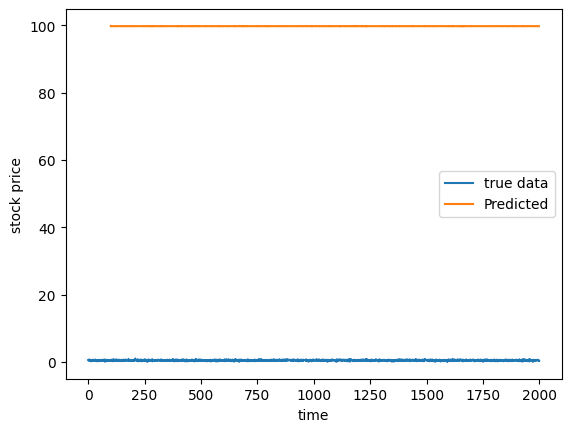

In [27]:
#Make the prediction
predictions = model.predict(X)
predictions = scaler.inverse_transform(prediction)

#plot the predictions
import matplotlib.pyplot as plt
plt.plot(data, label='true data')
plt.plot(np.arange(time_step,time_step+len(predictions)),prediction, label='Predicted')
plt.xlabel("time")
plt.ylabel('stock price')
plt.legend()
plt.show()